# Extraindo Caracteristicas Principais dos Dados Gerados de Supernovas

#### O Objetivo deste Notebook é gerar caracteristicas principais dos dados de supernova gerados no Notebook de Manipulação de Arquivos, que providencia os dados referentes aos picos e vales do sinal de supernova, bem como o espectro normalizado. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
'''
PROCESSAMENTO DE SINAIS
'''
from scipy.signal import savgol_filter
import scipy.integrate as integrate
import scipy.fftpack
import statsmodels.api as sm
from scipy.optimize import curve_fit
from scipy import optimize
from scipy.stats.distributions import  t
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
from scipy import interpolate
import scipy.stats as ss
'''
DATAFRAMES PANDAS
'''
import pandas as pd
from collections import OrderedDict
'''
ESTATISTICAS ESPECTRAIS
'''
import librosa
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
def salvaDataFrames_csv(dataFrame,caminhoSaida,nomeArquivo):
    dataFrame.to_csv(caminhoSaida+'\/'+nomeArquivo, sep=',', encoding = 'utf-8')
       
def salvaDataFrames_pkl(dataFrame,caminhoSaida,nomeArquivo):
    dataFrame.to_pickle(caminhoSaida+'\/'+nomeArquivo, compression='infer')

### Abrindo o dataFrame para supernovas Ia

In [3]:
caminhoDataframe = 'C:\/Users\/Ricardinho\/Desktop\/notebooks_Data_Science\/DataFrames\/' 

def abreDataFrame(caminho,nomeArq):
    dataFrame = pd.read_pickle(caminho + nomeArq)#READ PICKLE MUITO IMPORTANTE!!!!!
    return dataFrame

dataFrame_SN = abreDataFrame(caminhoDataframe, 'dataFrame_thermo.pkl')
dataFrame_SN.head(10)

,Nome_Supernova,Tipo,Fase,Tag_Fase,SNx_Redshifted,SNy_Redshifted,Valor_Redshift,Wl_Absorcao,pk_Absorcao,Valesx,Valesy,Wl_Emissao,pk_Emissao,Picosx,Picosy
0,SN_Redshifted_sn1998V-19980319.flm,Ia,-1.890,Maximo,"[3657.8171091445433, 3661.5775067102504, 3665....","[0.5984432965698894, 0.5905492293635906, 0.579...",0.0539,"[17.619215433334755, 57.31946665128062, 21.342...","[0.18021023580890244, 0.3243176017774667, 0.15...","[3733.0250604586895, 3793.191421510006, 3996.2...","[0.3130176858469804, 0.3015509334649366, 0.791...","[1.0118360413773377, 163.63754035206378, 300.8...","[0.016817304947432887, 0.8058522452437912, 1.0...","[3755.5874458529333, 3932.326131441176, 4071.4...","[0.3197765890370293, 0.9046622089121021, 0.968..."
1,SN_Redshifted_sn1998V-19980320.flm,Ia,-1.890,Maximo,"[3657.8171091445433, 3661.5775067102504, 3665....","[0.637192333491651, 0.6141274942884631, 0.5960...",0.0539,"[16.371018937613947, 64.2944024344855, 20.7707...","[0.1674436182667774, 0.34893402599080686, 0.15...","[3736.7854580243966, 3796.9518190757135, 4003....","[0.31617237791302105, 0.2923087716430614, 0.78...","[0.9141701804806469, 167.19453902302976, 139.1...","[0.015194041396336656, 0.8083987547571595, 1.0...","[3755.5874458529333, 3939.8469265725907, 4071....","[0.3185954230433903, 0.9012502335136664, 0.964..."
2,SN_Redshifted_sn1998V-19980321.flm,Ia,-0.956,Maximo,"[3657.8171091445433, 3661.546502254467, 3665.2...","[0.6570335303026084, 0.6753503669909301, 0.673...",0.0237,"[185.40637775724102, 21.358415820673404, 4.537...","[0.6810259254183335, 0.1590846850586145, 0.045...","[3788.3458679918863, 3997.1918821476347, 4138....","[0.2552889392094797, 0.803456614913874, 0.8579...","[12.312571117750375, 192.06947226829752, 141.7...","[0.09432841640783755, 0.9196702797739789, 1.0,...","[3661.546502254467, 3933.7921992789256, 4068.0...","[0.6753503669909301, 0.9427250499615443, 0.969..."
3,SN_Redshifted_sn1998dx-19980914.flm,Ia,-0.435,Maximo,"[3529.746655280387, 3533.3753907622395, 3537.0...","[0.9510331445835957, 0.8747050414260726, 0.822...",0.0170,"[212.44875440729388, 35.28210321823908, 86.394...","[0.542094651484383, 0.23714572395466332, 0.276...","[3722.0696358185683, 3997.8535324393565, 4291....","[0.42189037891622544, 0.676250566806941, 0.459...","[227.59655953321945, 232.49044388801792, 7.723...","[0.8252713893812736, 0.7909786778434359, 0.060...","[3921.6500873204545, 4070.428242076406, 4382.4...","[0.8907557494102819, 0.8823846210297399, 0.534..."
4,SN_Redshifted_sn1998dx-19980915.flm,Ia,-0.435,Maximo,"[3529.746655280387, 3533.3753907622395, 3537.0...","[0.9336562914191868, 0.8202276475798798, 0.749...",0.0170,"[21.710703139845464, 128.25771071955825, 41.25...","[0.21367836230340134, 0.45314122035985077, 0.2...","[3591.4351584718793, 3722.0696358185683, 3994....","[0.5887253091565299, 0.36673600558762776, 0.56...","[34.865542237806274, 157.97028029754966, 166.6...","[0.26689387783346896, 0.5804419788934498, 0.54...","[3631.3512487722564, 3914.3926163567494, 4081....","[0.630566051482265, 0.7546175525445505, 0.7453..."
5,SN_Redshifted_sn1998dx-19980917.flm,Ia,-0.435,Maximo,"[3529.746655280387, 3533.3753907622395, 3537.0...","[0.495615778559792, 0.6598588802703995, 0.7312...",0.0170,"[16.68940289378036, 13.076396011426443, 40.833...","[0.25551298910912457, 0.09008920653504715, 0.2...","[3569.6627455807643, 3729.3271067822734, 3798....","[0.5115434775288177, 0.3926142462191819, 0.355...","[39.916090300377164, 82.44579809249994, 3.5466...","[1.0, 0.5163694482104669, 0.051440996742034326...","[3540.6328617259446, 3605.950100399289, 3751.0...","[0.742741647615746, 0.6179282090302084, 0.3993..."
6,SN_Redshifted_sn1998dx-19980918.flm,Ia,-1.890,Maximo,"[3529.746655280387, 3533.3753907622395, 3537.0...","[0.5954063726305847, 0.6035925242893051, 0.619...",0.0539,"[7.496982253547999, 24.168174334791697, 16.477...","[0.09390927564713371, 0.17526893071660174, 0.1...","[3587.806422990027, 3736.584577745978, 3787.38...","[0.6305865631399746, 0.40897559572

## Análise de Componentes principais - PCA

A Análise de Componentes Principais (ACP) ou Principal Component Analysis (PCA) é um procedimento matemático que utiliza uma transformação ortogonal (ortogonalização de vetores) para converter um conjunto de observações de variáveis possivelmente correlacionadas num conjunto de valores de variáveis linearmente não correlacionadas chamadas de componentes principais. O número de componentes principais é menor ou igual ao número de variáveis originais. Esta transformação é definida de forma que o primeiro componente principal tem a maior variância possível (ou seja, é responsável pelo máximo de variabilidade nos dados), e cada componente seguinte, por sua vez, tem a máxima variância sob a restrição de ser ortogonal a (i.e., não correlacionado com) os componentes anteriores. Os componentes principais são garantidamente independentes apenas se os dados forem normalmente distribuídos (conjuntamente). O PCA é sensível à escala relativa das variáveis originais. Dependendo da área de aplicação, o PCA é também conhecido como transformada de Karhunen-Loève (KLT) discreta, transformada de Hotelling ou decomposição ortogonal própria (POD).

O PCA é matematicamente definido como uma transformação linear ortogonal que transforma os dados para um novo sistema de coordenadas de forma que a maior variância por qualquer projeção dos dados fica ao longo da primeira coordenada (o chamado primeiro componente), a segunda maior variância fica ao longo da segunda coordenada, e assim por diante.

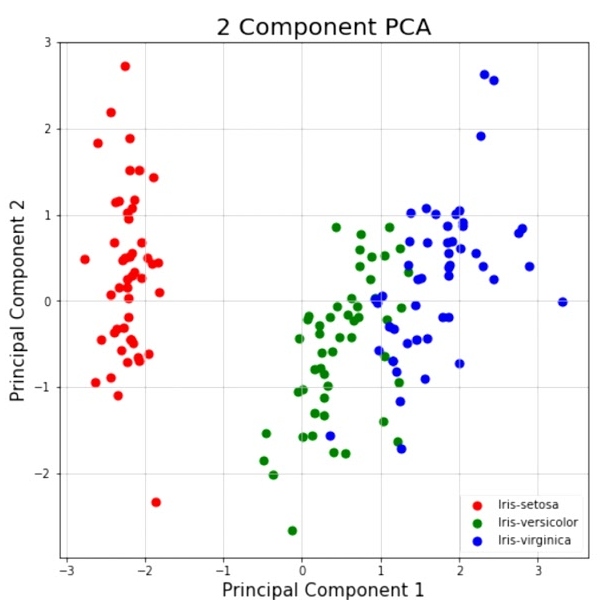

In [24]:
from IPython.display import Image
Image(filename="notebooks_Data_Science\img\pca.png",width = 600,height = 600)

#### A imagem acima indica em quantos componentes principais os dados de Iris foram transformados, este mesmo principio foi aplicado nos dados de supernova para os valores dos picos e dos vales, e para os valores de fluxo e de comprimento de onda das supernovas.

In [4]:
def transforma_Listas(data):
    vetorLista = []
    for i in range(len(data)):
        test = []
        test = data[i]
        
        lista = []
        for j in range(50):
            #lista.append(test[j])
            lista.append(0)
        
        for j in range(len(test)):
            lista[j] = test[j]
        
        vetor = np.array(lista)    
        vetorLista.append(vetor)
        
    return vetorLista

#### A função trasforma_listas tem por objetivo manipular os dados do dataframe e transformar cada lista de pico e de vale de tamanho variavel para uma lista de tamanho 50. Nesta lista os dados de pico e vale com tamanho variavel são inseridos e o restante recebe o valor de 0 para completar as 50 posições.

#### A Função gerandoPCA_DataFrame redebe o dataframe e produz os PCA's para as variaveis de largura equivalente, de intensidade de pico, os valores de fluxo de radiação e a posição de cada vale nos espectros.

In [5]:
def gerandoPCA_DataFrame(dataFrame):
    data1 = dataFrame_SN.loc[:,'SNy_Redshifted']
    data1 = data1.tolist()
    
    data2 = dataFrame_SN.loc[:,'Wl_Absorcao']
    data2 = data2.tolist()
    
    
    data3 = dataFrame_SN.loc[:,'pk_Absorcao']
    data3 = data3.tolist()
    
    data4 = dataFrame_SN.loc[:,'Valesx']
    data4 = data4.tolist()
    
    data5 = dataFrame_SN.loc[:,'Valesy']
    data5 = data5.tolist()
    
    
    '''
    Caracteristicas mantidas no dataframe original
    '''
    data6 = dataFrame_SN.loc[:,'SNx_Redshifted']
    data6 = data6.tolist()
     
    data7 = dataFrame_SN.loc[:,'Nome_Supernova']
    data7 = data7.tolist()
    
    data8 = dataFrame_SN.loc[:,'Tipo']
    data8 = data8.tolist()
    
    data9 = dataFrame_SN.loc[:,'Fase']
    data9 = data9.tolist()
    
    data10 = dataFrame_SN.loc[:,'Tag_Fase']
    data10 = data10.tolist()
    
    
    dataFrameFeatures = OrderedDict(
    {
     'Nome_SN':data7,
     'SNx':data6,
     'SNy':data1,
     'Fase':data9,
     'Tipo':data8,
     'Tag_Fase':data10
     })
    df = pd.DataFrame(dataFrameFeatures)
    
    
    '''
    requerimento para gerar o PCA
    X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
            
    Transformar SNy == (3082,1000)
    Transformar SNx == (3082,1000)        
    '''
    
    SNy = np.asarray(data1)
    Wl =  np.asarray(transforma_Listas(data2))
    pk =  np.asarray(transforma_Listas(data3))
    Vx =  np.asarray(transforma_Listas(data4))
    Vy =  np.asarray(transforma_Listas(data5))
   
    print(SNy.shape)
    print(Wl.shape)
    print(pk.shape)
    print(Vx.shape)
    print(Vy.shape)
    
    #gerando os PCAs
    pca = PCA(n_components=2)
    
    PCA_SNy = pca.fit_transform(SNy)
    PCA_Wl = pca.fit_transform(Wl)
    PCA_pk = pca.fit_transform(pk)
    PCA_Vx = pca.fit_transform(Vx)
    PCA_Vy = pca.fit_transform(Vy)
    
    principalDf_SNy = pd.DataFrame(data = PCA_SNy
             , columns = ['PCA_SNy_1', 'PCA_SNy_2'])

    principalDf_Wl = pd.DataFrame(data = PCA_Wl
             , columns = ['PCA_Wl_1', 'PCA_Wl_2'])

    principalDf_pk = pd.DataFrame(data = PCA_pk
             , columns = ['PCA_pk_1', 'PCA_pk_2'])

    principalDf_Vx = pd.DataFrame(data = PCA_Vx
             , columns = ['PCA_Vx_1', 'PCA_Vx_2'])

    principalDf_Vy = pd.DataFrame(data = PCA_Vy
             , columns = ['PCA_Vy_1', 'PCA_Vy_2'])

    
    dataFrame_Final = pd.concat([df,principalDf_SNy,principalDf_Wl,principalDf_pk,principalDf_Vx,principalDf_Vy],axis = 1)
    
    return dataFrame_Final

In [6]:
dataFrame_PCA = gerandoPCA_DataFrame(dataFrame_SN)

salvaDataFrames_csv(dataFrame_PCA,caminhoDataframe,'Data_Frame_Ia_PCA.csv')
salvaDataFrames_pkl(dataFrame_PCA,caminhoDataframe,'Data_Frame_Ia_PCA.pkl')

(3082, 1000)
(3082, 50)
(3082, 50)
(3082, 50)
(3082, 50)


In [7]:
dataFrame_PCA.head(5)

,Nome_SN,SNx,SNy,Fase,Tipo,Tag_Fase,PCA_SNy_1,PCA_SNy_2,PCA_Wl_1,PCA_Wl_2,PCA_pk_1,PCA_pk_2,PCA_Vx_1,PCA_Vx_2,PCA_Vy_1,PCA_Vy_2
0,SN_Redshifted_sn1998V-19980319.flm,"[3657.8171091445433, 3661.5775067102504, 3665....","[0.5984432965698894, 0.5905492293635906, 0.579...",-1.890,Ia,Maximo,-3.989887,-1.327662,-17.851989,-58.763694,-0.295126,0.105541,-6280.719189,-396.874181,-0.241119,0.373996
1,SN_Redshifted_sn1998V-19980320.flm,"[3657.8171091445433, 3661.5775067102504, 3665....","[0.637192333491651, 0.6141274942884631, 0.5960...",-1.890,Ia,Maximo,-4.102365,-1.263241,-135.387261,-76.271169,-0.411063,0.193588,1117.916273,4786.035451,-0.069201,0.484576
2,SN_Redshifted_sn1998V-19980321.flm,"[3657.8171091445433, 3661.546502254467, 3665.2...","[0.6570335303026084, 0.6753503669909301, 0.673...",-0.956,Ia,Maximo,-3.939491,-1.560221,14.502717,1954.732751,-0.044454,-0.272755,-4128.202144,2893.456010,-0.306284,0.584218
3,SN_Redshifted_sn1998dx-19980914.flm,"[3529.746655280387, 3533.3753907622395, 3537.0...","[0.9510331445835957, 0.8747050414260726, 0.822...",-0.435,Ia,Maximo,-4.463030,-1.872636,-58.875124,-63.035715,-0.456232,-0.202474,3706.066803,4403.288461,-0.213103,0.403622
4,SN_Redshifted_sn1998dx-19980915.flm,"[3529.746655280387, 3533.3753907622395, 3537.0...","[0.9336562914191868, 0.8202276475798798, 0.749...",-0.435,Ia,Maximo,-3.999763,-0.583957,-57.264638,-49.921607,-0.444915,0.115924,6098.139925,2879.216192,-0.138856,0.308748


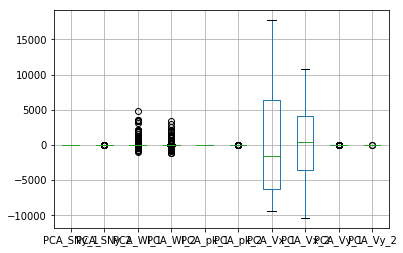

In [8]:
novo_Selecao = dataFrame_PCA[['Tipo','Tag_Fase','PCA_SNy_1','PCA_SNy_2','PCA_Wl_1','PCA_Wl_2','PCA_pk_1','PCA_pk_2','PCA_Vx_1','PCA_Vx_2','PCA_Vy_1','PCA_Vy_2']]
novo_Selecao = novo_Selecao.set_index(['Tipo'])#Tag_Fase agora é um indice

novo_Selecao.boxplot()

Current size: [6.0, 4.0]


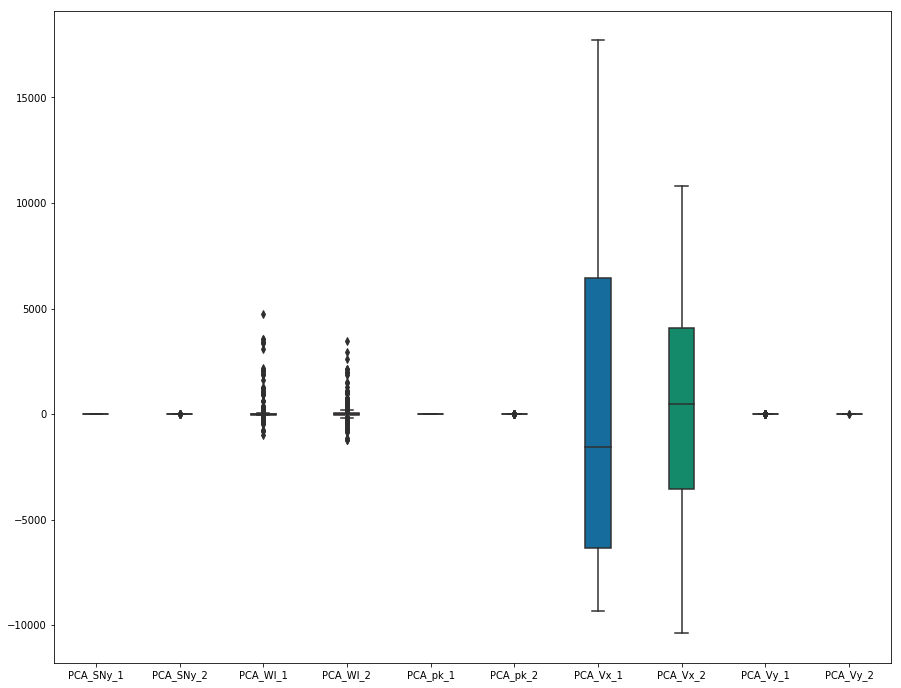

In [9]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print ("Current size:", fig_size)
 
# Set figure width to 12 and height to 9
fig_size[0] = 15
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

bplot=sns.boxplot(data=novo_Selecao, 
                 width=0.3,
                 palette="colorblind")

### Distribuição das variaveis de PCA

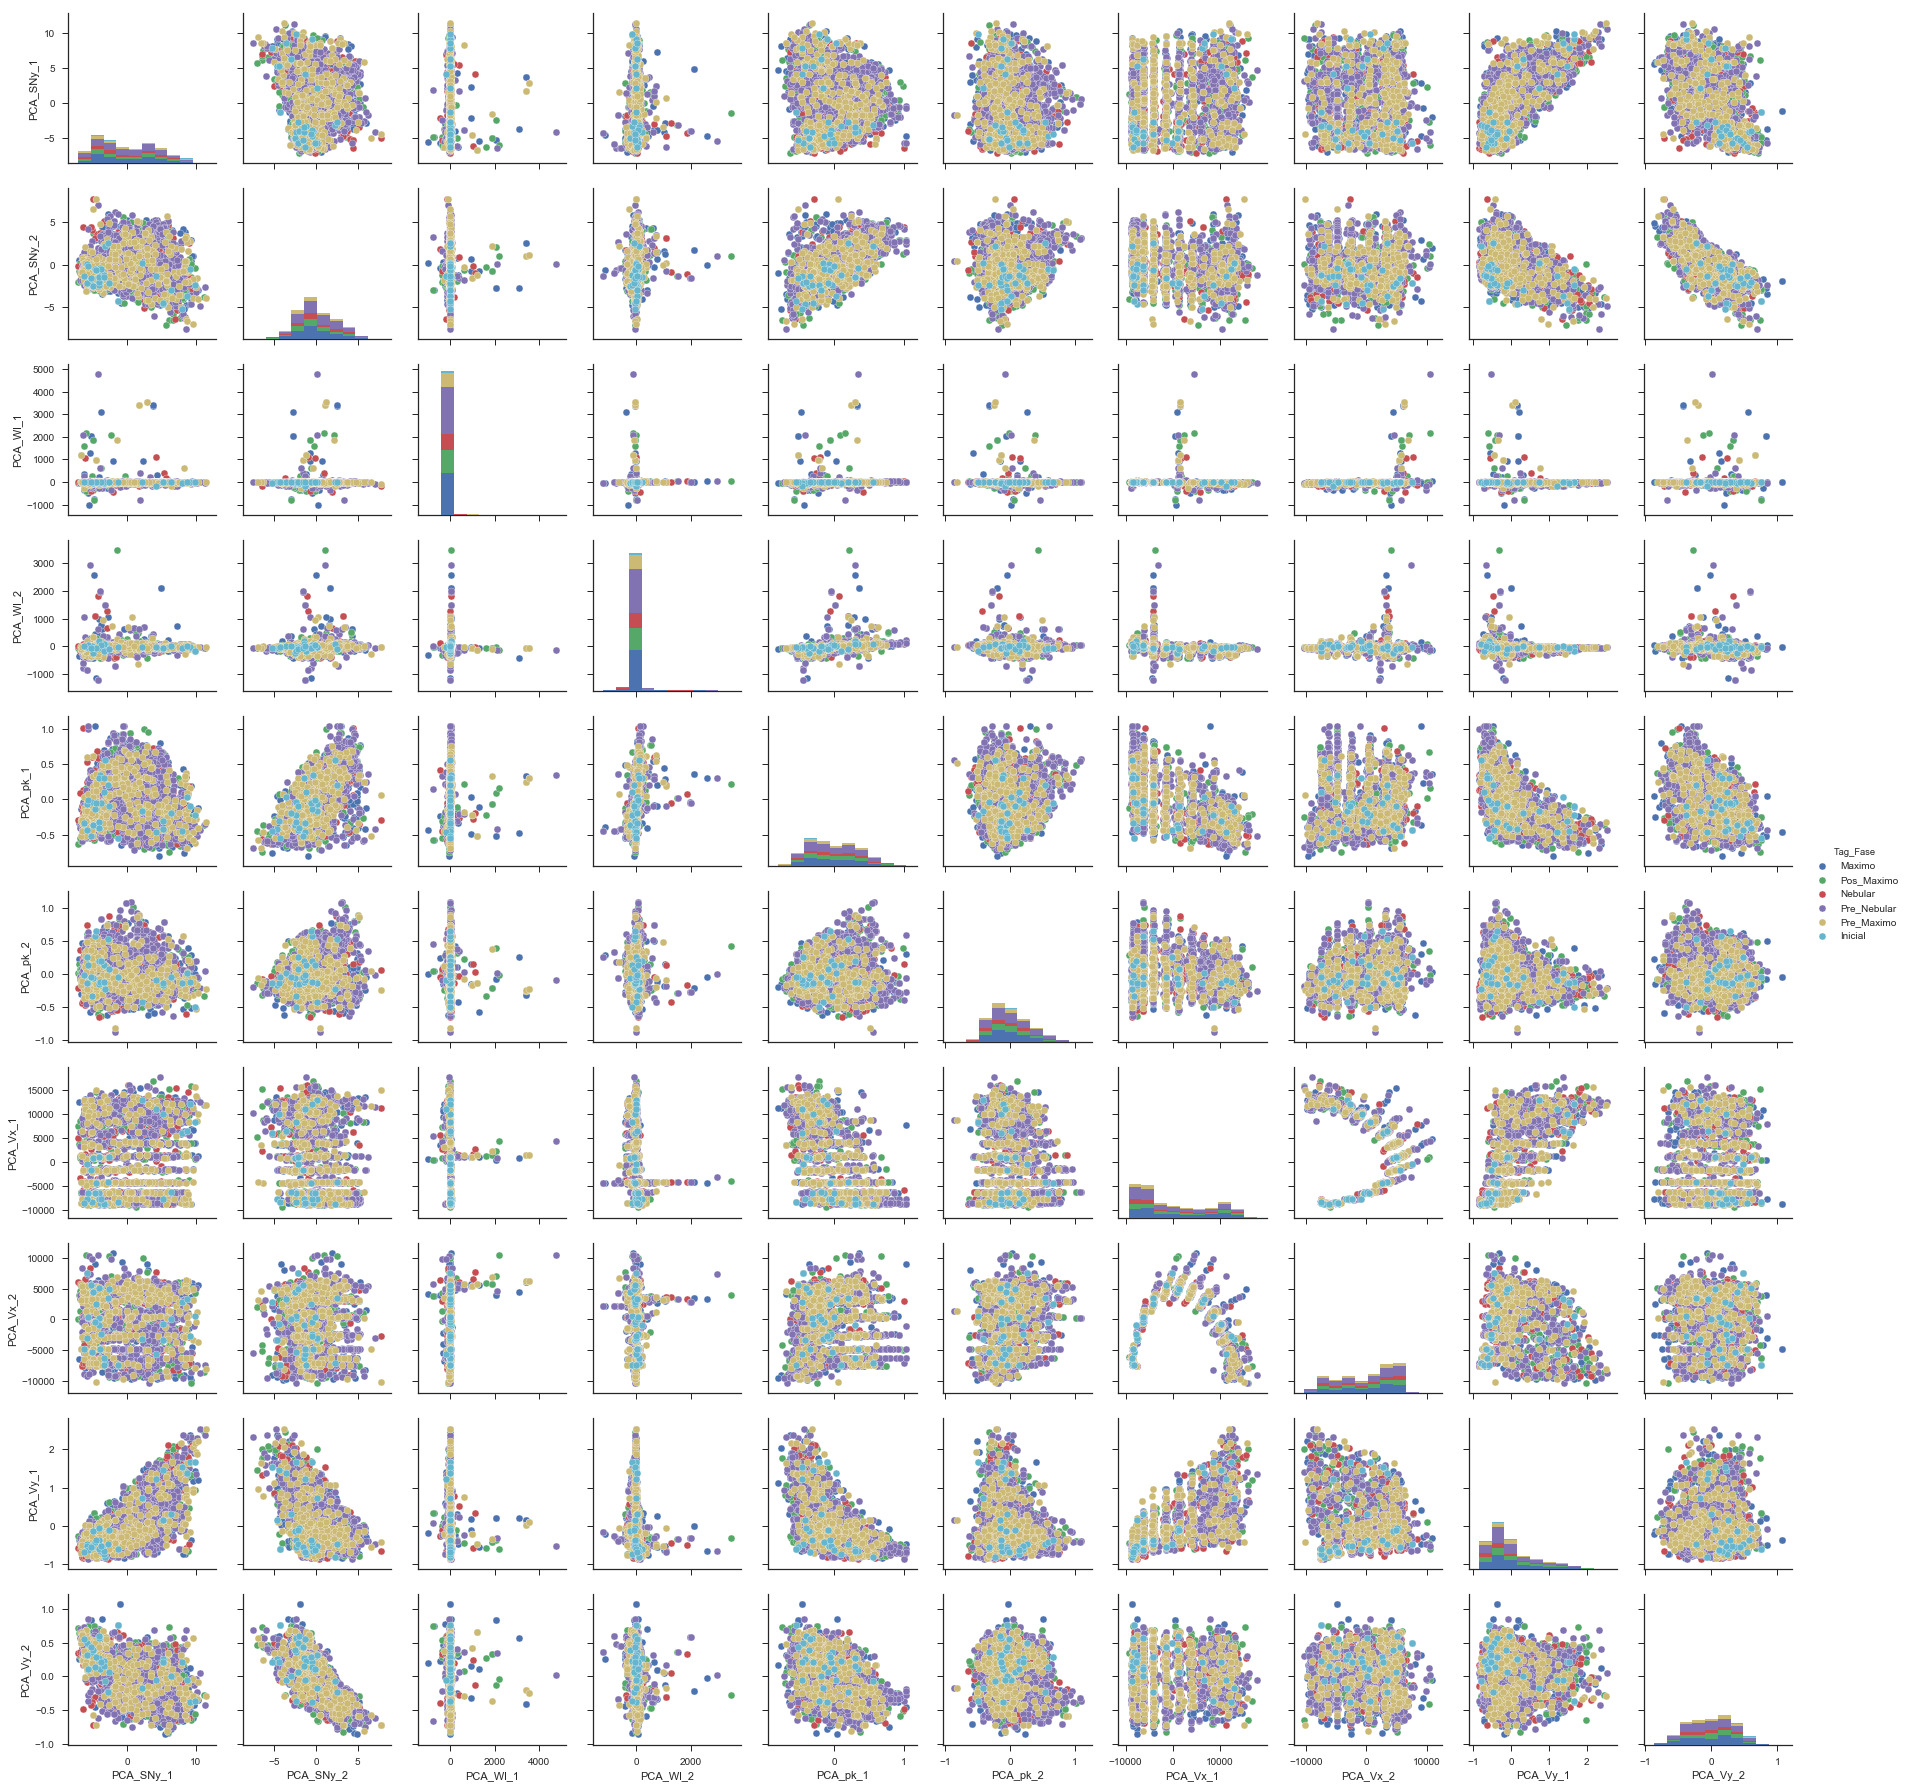

In [10]:
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(novo_Selecao, hue="Tag_Fase")

A imagem indica um agrupamento geral para cada um dos componentes principais, desta forma, os dados possuem uma caracteristica de não-linearidade muito forte. Aplicar tecnicas de separação e classificação lineares como redes neurais e regressoes não é suficiente para gerar bons resultados de classificação.

### Gera PCA para os comprimentos de onda e fluxo de radiação apenas para os picos e vales nos espectros.

In [11]:
def gerandoPCA_DataFrame_II(dataFrame):
    data1 = dataFrame_SN.loc[:,'SNy_Redshifted']
    data1 = data1.tolist()
    
    data2 = dataFrame_SN.loc[:,'Picosx']
    data2 = data2.tolist()
    
    
    data3 = dataFrame_SN.loc[:,'Picosy']
    data3 = data3.tolist()
    
    data4 = dataFrame_SN.loc[:,'Valesx']
    data4 = data4.tolist()
    
    data5 = dataFrame_SN.loc[:,'Valesy']
    data5 = data5.tolist()
    
    
    '''
    Caracteristicas mantidas no dataframe original
    '''
    data6 = dataFrame_SN.loc[:,'SNx_Redshifted']
    data6 = data6.tolist()
     
    data7 = dataFrame_SN.loc[:,'Nome_Supernova']
    data7 = data7.tolist()
    
    data8 = dataFrame_SN.loc[:,'Tipo']
    data8 = data8.tolist()
    
    data9 = dataFrame_SN.loc[:,'Fase']
    data9 = data9.tolist()
    
    data10 = dataFrame_SN.loc[:,'Tag_Fase']
    data10 = data10.tolist()
    
    
    dataFrameFeatures = OrderedDict(
    {
     'Nome_SN':data7,
     'SNx':data6,
     'SNy':data1,
     'Fase':data9,
     'Tipo':data8,
     'Tag_Fase':data10
     })
    df = pd.DataFrame(dataFrameFeatures)
    
    
    '''
    requerimento para gerar o PCA
    X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
            
    Transformar SNy == (3082,1000)
    Transformar SNx == (3082,1000)        
    '''
    
    Px =  np.asarray(transforma_Listas(data2))
    Py =  np.asarray(transforma_Listas(data3))
    Vx =  np.asarray(transforma_Listas(data4))
    Vy =  np.asarray(transforma_Listas(data5))
   
    print(Px.shape)
    print(Py.shape)
    print(Vx.shape)
    print(Vy.shape)
    
    #gerando os PCAs
    pca = PCA(n_components=2)
    
  
    PCA_Px = pca.fit_transform(Px)
    PCA_Py = pca.fit_transform(Py)
    PCA_Vx = pca.fit_transform(Vx)
    PCA_Vy = pca.fit_transform(Vy)


    principalDf_Px = pd.DataFrame(data = PCA_Px
             , columns = ['PCA_Px_1', 'PCA_Px_2'])

    principalDf_Py = pd.DataFrame(data = PCA_Py
             , columns = ['PCA_Py_1', 'PCA_Py_2'])

    principalDf_Vx = pd.DataFrame(data = PCA_Vx
             , columns = ['PCA_Vx_1', 'PCA_Vx_2'])

    principalDf_Vy = pd.DataFrame(data = PCA_Vy
             , columns = ['PCA_Vy_1', 'PCA_Vy_2'])

    
    dataFrame_Final = pd.concat([df,principalDf_Px,principalDf_Py,principalDf_Vx,principalDf_Vy],axis = 1)
    
    return dataFrame_Final

In [12]:
dataFrame_PCA_II = gerandoPCA_DataFrame_II(dataFrame_SN)

salvaDataFrames_csv(dataFrame_PCA_II,caminhoDataframe,'Data_Frame_Ia_PCA_II.csv')
salvaDataFrames_pkl(dataFrame_PCA_II,caminhoDataframe,'Data_Frame_Ia_PCA_II.pkl')

(3082, 50)
(3082, 50)
(3082, 50)
(3082, 50)


In [13]:
dataFrame_PCA_II.head(5)

,Nome_SN,SNx,SNy,Fase,Tipo,Tag_Fase,PCA_Px_1,PCA_Px_2,PCA_Py_1,PCA_Py_2,PCA_Vx_1,PCA_Vx_2,PCA_Vy_1,PCA_Vy_2
0,SN_Redshifted_sn1998V-19980319.flm,"[3657.8171091445433, 3661.5775067102504, 3665....","[0.5984432965698894, 0.5905492293635906, 0.579...",-1.890,Ia,Maximo,-6458.880203,-655.708442,-0.444330,0.048064,-6280.719189,-396.874182,-0.241119,0.373996
1,SN_Redshifted_sn1998V-19980320.flm,"[3657.8171091445433, 3661.5775067102504, 3665....","[0.637192333491651, 0.6141274942884631, 0.5960...",-1.890,Ia,Maximo,-2137.843934,3937.730133,-0.275439,0.112216,1117.916273,4786.035450,-0.069201,0.484576
2,SN_Redshifted_sn1998V-19980321.flm,"[3657.8171091445433, 3661.546502254467, 3665.2...","[0.6570335303026084, 0.6753503669909301, 0.673...",-0.956,Ia,Maximo,-4579.883496,2143.853840,-0.423004,0.239782,-4128.202144,2893.456010,-0.306284,0.584218
3,SN_Redshifted_sn1998dx-19980914.flm,"[3529.746655280387, 3533.3753907622395, 3537.0...","[0.9510331445835957, 0.8747050414260726, 0.822...",-0.435,Ia,Maximo,3484.079226,4660.968716,-0.412396,0.413321,3706.066803,4403.288462,-0.213103,0.403622
4,SN_Redshifted_sn1998dx-19980915.flm,"[3529.746655280387, 3533.3753907622395, 3537.0...","[0.9336562914191868, 0.8202276475798798, 0.749...",-0.435,Ia,Maximo,3294.567153,4491.130144,-0.331301,0.292613,6098.139925,2879.216191,-0.138856,0.308748


In [14]:
novo_Selecao_II = dataFrame_PCA_II[['Tipo','Tag_Fase','PCA_Py_1','PCA_Py_2','PCA_Vy_1','PCA_Vy_2']]
novo_Selecao_II = novo_Selecao_II.set_index(['Tipo'])#Tag_Fase agora é um indice

Current size: [15.0, 12.0]


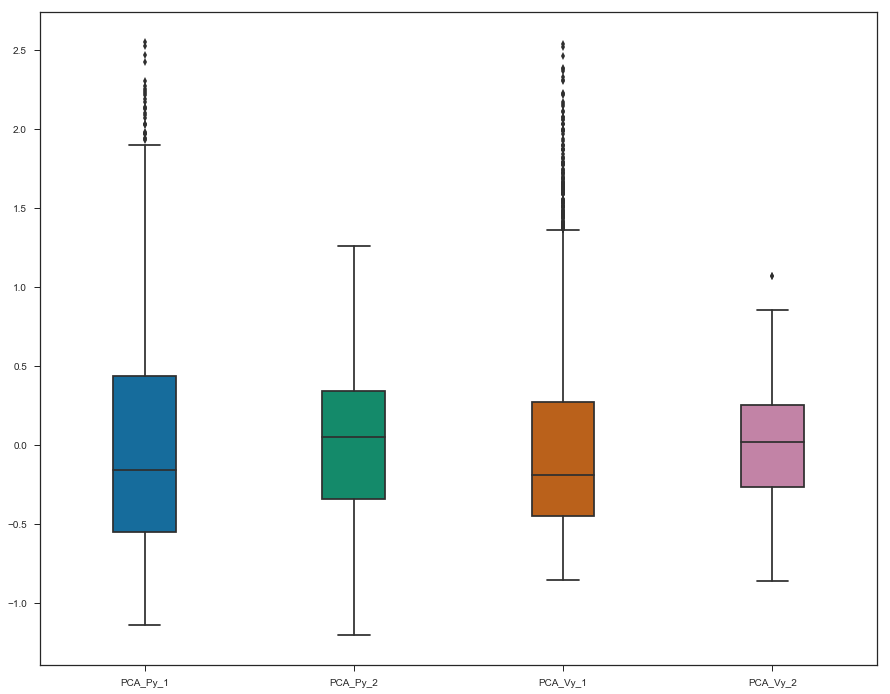

In [15]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print ("Current size:", fig_size)
 
# Set figure width to 12 and height to 9
fig_size[0] = 15
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

bplot=sns.boxplot(data=novo_Selecao_II, 
                 width=0.3,
                 palette="colorblind")

### Gera a vizualização dos componentes principais gerados para as variaveis

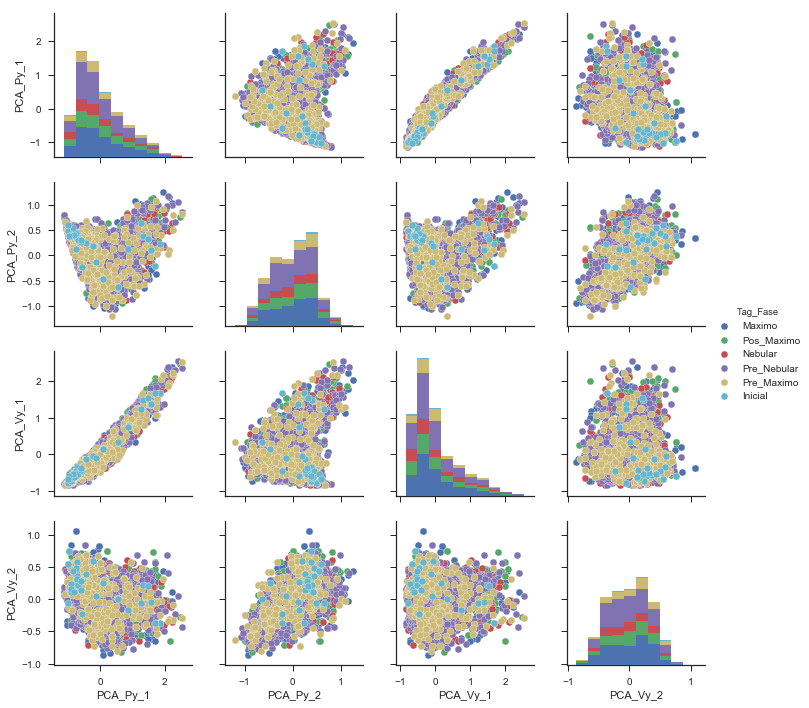

In [16]:
sns.set(style="ticks")
sns.pairplot(novo_Selecao_II, hue="Tag_Fase")

A imagem indica um agrupamento geral para cada um dos componentes principais, desta forma, os dados possuem uma caracteristica de não-linearidade muito forte. Aplicar tecnicas de separação e classificação lineares como redes neurais e regressoes não é suficiente para gerar bons resultados de classificação.

## Gerando PCA para todos os valores de X e de Y nos espectros normalizados

In [17]:
def gerandoPCA_XY(dataFrame):
    
    '''
    dados basicos que sempre ficam no dataframe
    '''
    data1 = dataFrame_SN.loc[:,'SNx_Redshifted']
    data1 = data1.tolist()
    
    data2 = dataFrame_SN.loc[:,'SNy_Redshifted']
    data2 = data2.tolist()
    
    data3 = dataFrame_SN.loc[:,'Nome_Supernova']
    data3 = data3.tolist()
    
    data4 = dataFrame_SN.loc[:,'Tipo']
    data4 = data4.tolist()
    
    data5 = dataFrame_SN.loc[:,'Fase']
    data5 = data5.tolist()
    
    data6 = dataFrame_SN.loc[:,'Tag_Fase']
    data6 = data6.tolist()
    
    #gera o 1st data frame
    dataFrameFeatures = OrderedDict(
    {
     'Nome_SN':data3,
     'SNx':data1,
     'SNy':data2,
     'Fase':data5,
     'Tipo':data4,
     'Tag_Fase':data6
     })
    df = pd.DataFrame(dataFrameFeatures)
    
    '''
    requerimento para gerar o PCA
    X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
            
    Transformar SNy == (3082,1000)
    Transformar SNx == (3082,1000)        
    '''
    
    SNx = np.asarray(data1)
    SNy = np.asarray(data2)
    print(SNx.shape)
    
    #gerando os PCAs
    pca = PCA(n_components=4)
    
    PCA_SNx = pca.fit_transform(SNx)
    
    PCA_SNy = pca.fit_transform(SNy)
    
    principalDf = pd.DataFrame(data = PCA_SNx
             , columns = ['PCA_SNx_1', 'PCA_SNx_2','PCA_SNx_3', 'PCA_SNx_4'])
    
    principalDf_y = pd.DataFrame(data = PCA_SNy
             , columns = ['PCA_SNy_1', 'PCA_SNy_2','PCA_SNy_3', 'PCA_SNy_4'])
    
    dataFrame_Final = pd.concat([df,principalDf,principalDf_y],axis = 1)
    
    return dataFrame_Final

In [18]:
dataFrame_PCA_XY = gerandoPCA_XY(dataFrame_SN)

salvaDataFrames_csv(dataFrame_PCA_XY,caminhoDataframe,'Data_Frame_Ia_PCA_XY.csv')
salvaDataFrames_pkl(dataFrame_PCA_XY,caminhoDataframe,'Data_Frame_Ia_PCA_XY.pkl')

(3082, 1000)


In [19]:
dataFrame_PCA_XY.head(5)

,Nome_SN,SNx,SNy,Fase,Tipo,Tag_Fase,PCA_SNx_1,PCA_SNx_2,PCA_SNx_3,PCA_SNx_4,PCA_SNy_1,PCA_SNy_2,PCA_SNy_3,PCA_SNy_4
0,SN_Redshifted_sn1998V-19980319.flm,"[3657.8171091445433, 3661.5775067102504, 3665....","[0.5984432965698894, 0.5905492293635906, 0.579...",-1.890,Ia,Maximo,1067.728793,1559.146097,7.421434e-10,-3.382472e-12,-3.989887,-1.327662,-1.906058,1.198017
1,SN_Redshifted_sn1998V-19980320.flm,"[3657.8171091445433, 3661.5775067102504, 3665....","[0.637192333491651, 0.6141274942884631, 0.5960...",-1.890,Ia,Maximo,1067.728793,1559.146097,7.409506e-10,1.220192e-11,-4.102365,-1.263241,-1.900481,1.228636
2,SN_Redshifted_sn1998V-19980321.flm,"[3657.8171091445433, 3661.546502254467, 3665.2...","[0.6570335303026084, 0.6753503669909301, 0.673...",-0.956,Ia,Maximo,503.000753,1591.195877,7.456314e-10,-7.024128e-14,-3.939491,-1.560221,-2.191264,0.987669
3,SN_Redshifted_sn1998dx-19980914.flm,"[3529.746655280387, 3533.3753907622395, 3537.0...","[0.9510331445835957, 0.8747050414260726, 0.822...",-0.435,Ia,Maximo,-4946.086051,-129.305816,7.446961e-10,-1.072000e-12,-4.463030,-1.872636,1.136015,0.552185
4,SN_Redshifted_sn1998dx-19980915.flm,"[3529.746655280387, 3533.3753907622395, 3537.0...","[0.9336562914191868, 0.8202276475798798, 0.749...",-0.435,Ia,Maximo,-4946.086051,-129.305816,7.446961e-10,-1.072000e-12,-3.999763,-0.583957,1.597298,0.534887


In [20]:
novo_Selecao_XY = dataFrame_PCA_XY[['Tipo','Tag_Fase','PCA_SNx_1', 'PCA_SNx_2','PCA_SNx_3', 'PCA_SNx_4','PCA_SNy_1', 'PCA_SNy_2','PCA_SNy_3', 'PCA_SNy_4']]
novo_Selecao_XY = novo_Selecao_XY.set_index(['Tipo'])#Tag_Fase agora é um indice

Current size: [15.0, 12.0]


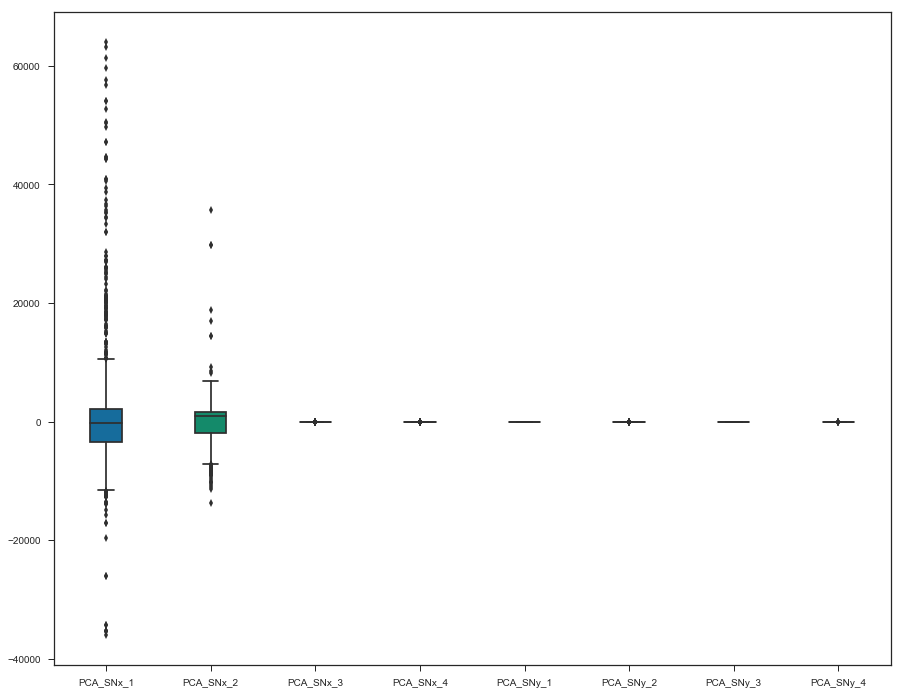

In [21]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print ("Current size:", fig_size)
 
# Set figure width to 12 and height to 9
fig_size[0] = 15
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

bplot=sns.boxplot(data=novo_Selecao_XY, 
                 width=0.3,
                 palette="colorblind")

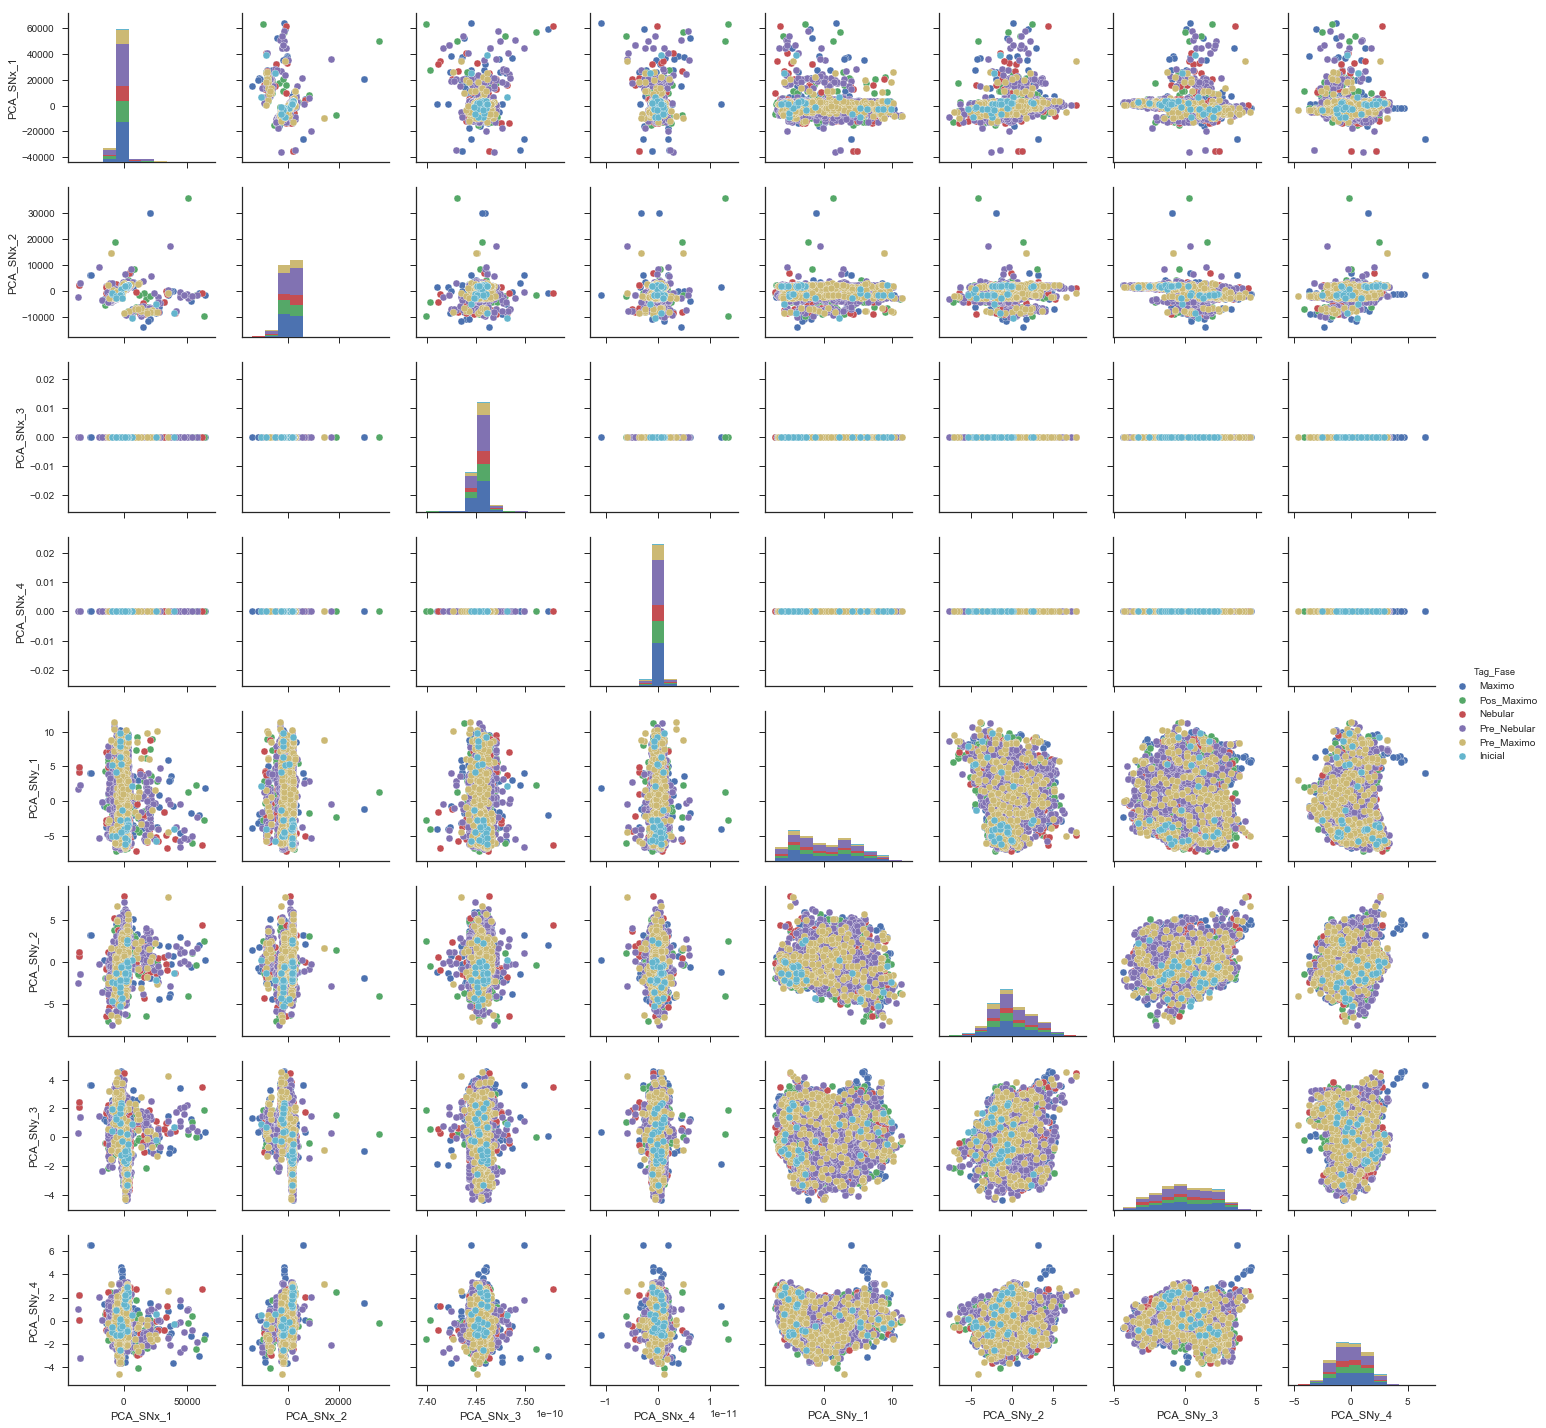

In [22]:
sns.set(style="ticks")
sns.pairplot(novo_Selecao_XY, hue="Tag_Fase")

### Os componentes principais indicam que para estes dados existe um compotamento muito parecido, isto se dá, pois todos os objetos pertencem a uma unica classe, as supernova de tipo Ia. Neste trabalho o objetivo é verificar a peculiaridade dos espectros deste tipo no decorrer do tempo e apartir disso gerar esquemas de classificação que modelem todas as fases das supernovas de tipo Ia.

### O notebook de agrupamento K-means realiza uma análise não supervisionada para encontrar os grupos gerados pelos dados de PCA.